<a href="https://colab.research.google.com/github/ashmcmn/brain_MRI_estimations/blob/master/One_Component_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   qBOLD model proposed by Yablonskiy and Haacke.

*   Transverse magnetisation is the component of the net magnetisation vector perpendicular to the magnetic field (x-y plane). This is due to the spins of individual protons getting more or less into phase (coherence) – i.e. after a radiofrequency pulse.

*   OEF (Oxygen Extraction Function) is a measure of the efficiency of oxygen utilization, it's defined as the ratio of blood oxygen that a tissue takes from the blood flow to maintain function.

*   Describes how transverse magnetisation in bulk tissue changes in the presence of blood vessels whose susceptibility difference is proportional to OEF.

*   The protons in the surrounding tissue are assumed to be relatively stationary with respect to the vessels.

*   Blood vessels are randomly oriented, infinitely long cylinders with uniform magnetic susceptiblity.

*   Allows the signal originating from surrounding tissues to be given by:
>$S^{t}(t) = exp(-R^{t}_{2}*t)*(-DBV*\int^1_0 \frac{(2+u)\sqrt{1-u}}{3*u^2}(1-J_0(\frac{3}{2}\delta\omega tu))du)$

*   $R^t_2$ is the irreversible transverse relaxation rate of bulk tissue
*   $J_0(x)$ is the zero-order Bessel function of x
*   $\delta\omega$ is the chracteristic frequency, given by:
>$\delta\omega = \frac{4}{3}\pi*\gamma B_0*\Delta\chi_0*Hct*OEF$

*   $\gamma$ is the proton gyromagnetic ratio
*   $\Delta\chi_0$ is the susceptibility difference between the tissue and deoxyhemoglobin contained within blood vessels
*   Hct is the fractional hemocrit.

# Prepation/Dependencies
This section of code is used to prepare the enviroment (reset on runtime for colab). The following libraries are imported:
*   nibabel - used for importing/exporting neuroimaging data
*   numpy - used for high-level mathematical operations such as matrix multiplication, also used for finding the least squares gradient and coefficient
*   matplotlib - used to better understand debugging with graph plots and displaying brain scans
*   nilearn - used for displaying brain scans
*   colab.drive - used to mount a drive containing permanent files



In [ ]:
# dependencies
!pip install nibabel
!pip install nilearn
import nibabel as nb
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting as nlp
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/My Drive/3rd Year/FYP/slice4_ASE.nii.gz" "/content/slice4_ASE.nii.gz"
!yes n | gunzip "/content/slice4_ASE.nii.gz"

np.seterr(divide = 'ignore') 

# Visual Validation of Data
This code displays the 10 slices of the data so that its format can be verified.

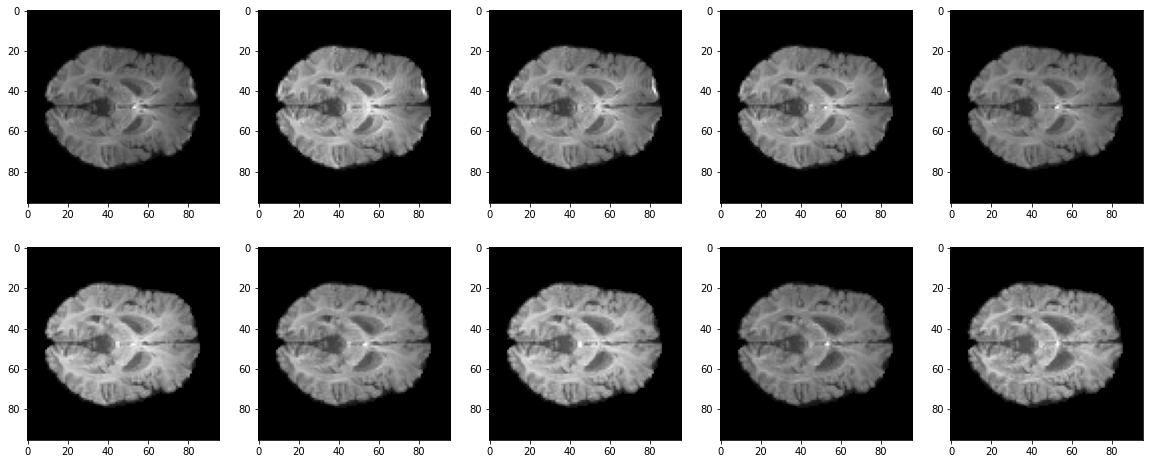

In [ ]:
nii = nb.load('slice4_ASE.nii')
dim = nii.header.get_data_shape()
data = nii.get_fdata()
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()
for i in range(10):
  axes[i].imshow(np.squeeze(data)[:,:,i], cmap='Greys_r')

# One-Compartment Model - Least Square Fit
The code below uses the one compartment model representation of the brain's blood vessel network and a least square fitting of the mri signals to physiological parameters.

In [ ]:
def signal_to_quant(data, tau_conf, tc, verbose=False):
  # defining constants
  hct = 0.34; # Expected proportion of hematocrit(volume percentage of red blood cells in blood)
  dChi0 = 0.264*10**-6; # Difference in magnetic susceptibility between the tissue and deoxyhaemoglobin contained within blood vessels
  gamma = 2.675*10**4; # Proton gyromagnetic ratio
  B0 = 3*10**4; # Strength of main magnetic field
  phi = 1.34; # Oxyphoric capacitiy in mlO2/gHb
  conv = 0.03; # Conversion factor

  tau = np.array([t*10**-3 for t in range(*tau_conf)]) # calculate the echo times when signal was measured
  if verbose: print('Tau values calculated to be: {}'.format(', '.join([str(t) for t in tau])))

  log_signal = np.log(data) # log transform the signals so that they can be fit to the model
  tau_r1 = np.where(tau < tc)[0] # split the tau values into regimes based on characteristic time
  tau_r2 = np.where(tau > tc)[0]

  W = np.sqrt(np.diag((1. / np.take(tau, tau_r2)).T)) # calculate weightings for tau values in the 2nd regime
  p = np.zeros((*data.shape[:-1], 2)) # create matrix to store gradients and coefficients for each voxel
  
  for x in range(data.shape[0]):
    for y in range(data.shape[1]):
      for z in range(data.shape[2]):
        X = tau[tau_r2] # x coordinates for graph are tau values of 2nd regime
        X = np.vstack([X, np.ones(len(X))]).T
        Xw = np.dot(W, X) # apply weights to x values

        Y = log_signal[x,y,z,tau_r2] # y coordinates for graph are signal strength at given voxel
        Yw = np.dot(Y.T, W) # apply weights to y values
        
        p[x,y,z,:] = np.linalg.lstsq(Xw, Yw.T, rcond=None)[0] # find least squares solutions for given 'graph' data

  s0_idx = np.where(tau == 0)[0][0] # get index of tau value 0

  r2p = -p[:,:,:,0] # get reversible relaxation rates from gradients
  c = p[:,:,:,1] # coefficients

  dbv = c - log_signal[:,:,:,s0_idx].reshape(log_signal.shape[0],log_signal.shape[0],1)
  oef = (3*r2p)/(4*np.pi*gamma*B0*dChi0*hct*dbv)
  dhb = (3*r2p)/(4*np.pi*gamma*B0*dChi0*conv*dbv)

  if verbose:
    _ = plt.imshow(np.squeeze(r2p), cmap='PRGn')
    plt.colorbar()
    plt.show()
    print('Mean R2 prime: {:.2f}'.format(np.nanmean(r2p)))

    _ = plt.imshow(np.squeeze(dbv), cmap='coolwarm')
    plt.colorbar()
    plt.show()
    print('Mean DBV: {:.0f}%'.format(np.nanmean(dbv)*100))

  return (r2p, dbv, oef, dhb, p, log_signal[:,:,:,s0_idx].reshape(log_signal.shape[0],log_signal.shape[0],1))

In [ ]:
nii = nb.load('slice4_ASE.nii')
signal_to_quant(nii.get_fdata(), [-16, 65, 8], 0.017, False)

Now that a line of best fit has been derived it is possible to reverse this process with some noise to create new anatomically accurate mri signals.

>$OEF = \frac{3*R2^{'}}{4\pi*\gamma B0*dChi0*Hct*DBV}$

>$R2^{'} = \frac{4}{3}\pi*\gamma B0*dChi0*Hct*DBV$

In [ ]:
oef = np.arange(0.20, 0.70, 0.01)
dbv = np.arange(0.03, 0.15, 0.0024)

S0 = ln_Sase[:,:,:,s0_id].reshape(ln_Sase.shape[0],ln_Sase.shape[0],1)

cf = (4/3)*np.pi*gamma*B0*dChi0*hct*oef

signal = np.zeros_like(data)

for i, t in enumerate(tau):
  if t < Tc:
    signal[:,:,:,i] = np.e**(S0 * np.exp(11.5 * 0.0074) * np.exp((-3/10) * dbv[0] * (cf[0] * t)**2))
  else:
    signal[:,:,:,i] = np.e**(S0 * np.exp(11.5 * 0.0074) * np.exp(dbv[0] - (dbv[0] * cf[0] * t)))

fig, axes = plt.subplots(4, 5, figsize=(20, 14))
axes = axes.ravel()
for i in range(20):
  if i < 10:
    axes[i].imshow(np.squeeze(data)[:,:,i], cmap='Greys_r')
  else:
    axes[i].imshow(signal[:,:,0,i-10], cmap='Greys_r')

# Figure Generation
The code below is used for generating figures to be used in the report body.

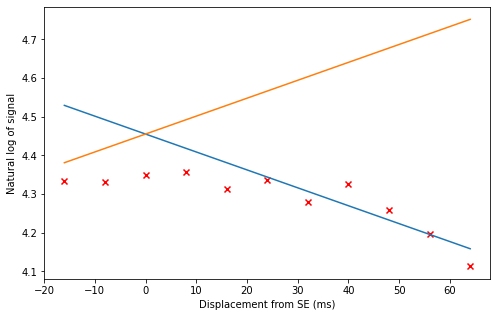

In [ ]:
# figure for demonstrating the ASE qBOLD signal derivation
_, dbv, _, _, p, s0 = signal_to_quant(nii.get_fdata(), [-16, 65, 8], 0.017, False)

X = 40
Y = 40

r2p = -p[X,Y,:,0]
c = p[X,Y,:,1]
s0 = s0[X,Y,0]
dbv = dbv[X,Y,0]

x = np.arange(-0.016, 0.065, 0.001)

y_r1 = (-r2p * x) + c
y_r2 = (r2p * x) + c
y_quad = np.log(nii.get_fdata())[X,Y,0,:]

x = np.multiply(x, 10**3)

fig, ax = plt.subplots(figsize=(8,5))
plt.xlabel('Displacement from SE (ms)')
plt.ylabel('Natural log of signal')
ax.plot(x, y_r1)
ax.plot(x, y_r2)
ax.scatter(np.arange(-16, 65, 8), y_quad, marker='x', c='red')